# Time Series Forecasting Using the Prophet Framework

This project is dedicated to developing a time series forecasting model using the Prophet framework. Prophet, created by Facebook's Core Data Science team, is a tool designed for forecasting time series data. It is particularly adept at handling data that exhibits seasonal trends and is effective in situations where the data includes several seasons of historical information. One of the key strengths of Prophet is its robustness against missing data and its ability to adapt to changes in trends, making it suitable for a wide range of practical applications.

## Facebook's Prophet

The Prophet framework, developed by Facebook's Core Data Science team, is a forecasting tool designed for a wide range of time series data. Prophet is particularly effective for data with strong seasonal effects and several seasons of historical data. It is also robust to missing data and shifts in the trend, making it suitable for practical applications with real-world data.

Prophet is built on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. The model is formulated as follows:

$$ y(t) = g(t) + s(t) + h(t) + \epsilon_t $$

Where:
- $y(t)$ is the predicted value.
- $g(t)$ represents the trend function, modeling non-periodic changes.
- $s(t)$ represents periodic changes (seasonality).
- $h(t)$ represents the effects of holidays.
- $\epsilon_t$ represents the error term accounting for any idiosyncratic changes not accommodated by the model.

### Trend Component: $g(t)$

Prophet supports two types of trend models: a saturating growth model and a piecewise linear model. The saturating growth model is useful when the value to be predicted is expected to reach a carrying capacity, i.e., a maximum achievable point. The piecewise linear model is suitable for data without a clear saturation point.

### Seasonality Component: $s(t)$

Seasonality in Prophet is modeled using Fourier series to provide a flexible approach to fitting seasonal data. This allows capturing daily, weekly, and yearly seasonality.

### Holiday Component: $h(t)$

Prophet allows incorporating holidays and events, which can be irregular, into the model. This is particularly useful for forecasting retail sales data, where holidays can significantly impact sales figures.

### Model Fitting

Prophet uses a Bayesian approach to estimate the model parameters. The underlying implementation of this fitting procedure is done using the Stan modeling language, allowing for automatic seasonality and trend detection and handling of missing data.

The flexibility and robustness of Prophet make it a powerful tool for time series forecasting, especially in scenarios where the data exhibits complex patterns such as strong seasonality and holiday effects.


# Imports

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

warnings.filterwarnings("ignore")

/mnt/3273eabb-9e14-47b4-8ddd-ddb77dddcd30/workspace/RossmannSalesForecasting/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Data Preparation

Again, we'll focus on forecasting sales data specifically for Store 2. This decision is driven by a strategic approach to model development and validation. By concentrating on a single store, we can more closely analyze and understand the unique trends, seasonal patterns, and factors influencing sales at a localized level.

The data transformation process for Store 2 will involve adapting the dataset to suit Prophet's requirements. This means renaming the date column to `ds` and the target sales variable to `y`. With missing values and outliers already addressed, our primary task is to ensure the dataset is correctly structured for Prophet's analysis. Moreover, incorporating store-specific variables, such as state holidays or promotions, can significantly enhance the model's predictive accuracy and relevance.

### Data Loading

In [2]:
root_data_folder = "data"
raw_data_folder = os.path.join(root_data_folder, "raw")
processed_data_folder = os.path.join(root_data_folder, "processed")

In [3]:
stores_sales_df = pd.read_parquet(
    os.path.join(processed_data_folder, "stores-sales.parquet")
)

sample_store_data = (
    stores_sales_df[stores_sales_df["Store"] == 2]
)[["Sales", "StateHoliday", "Promo"]]

sample_store_data

,Sales,StateHoliday,Promo
Date,,,
2013-01-01,0,a,0
2013-01-02,4422,0,0
2013-01-03,4159,0,0
2013-01-04,4484,0,0
2013-01-05,2342,0,0
...,...,...,...
2015-07-27,6627,0,1
2015-07-28,5671,0,1
2015-07-29,6402,0,1


### Data Resampling

We'll resample the daily data into weekly total, in the same way we did in with the SARIMA model. The same must be done with the `StateHoliday` and `Promo` features.

In [4]:
weekly_features = sample_store_data["Sales"].resample("W").sum().reset_index()

weekly_features["StateHoliday"] = (
    sample_store_data["StateHoliday"]
        .map({"0": 0, "a": 1, "b": 2, "c": 3})
        .resample("W")
        .max()
        .reset_index(drop=True)
)

weekly_features["Promo"] = (
    sample_store_data["Promo"]
        .resample("W")
        .max()
        .reset_index(drop=True)
)

# Rename the columns as required by Prophet
weekly_features = weekly_features.rename(columns={"Date": "ds", "Sales": "y"})
weekly_features

,ds,y,StateHoliday,Promo
0,2013-01-06,15407,1,0
1,2013-01-13,32914,0,1
2,2013-01-20,21081,0,0
3,2013-01-27,29973,0,1
4,2013-02-03,23297,0,0
...,...,...,...,...
130,2015-07-05,39757,0,1
131,2015-07-12,25264,0,0
132,2015-07-19,32399,0,1
133,2015-07-26,23838,0,0


### Data Split

Again, we'll collect the 20% more recent data for validation and the reamaining will be used for training.

In [5]:
data_len = len(weekly_features.index)
test_len = int(data_len * 0.2)

train_df = weekly_features.iloc[:-test_len].reset_index(drop=True)
test_df = weekly_features.iloc[-test_len:].reset_index(drop=True)

display(train_df)
display(test_df)

,ds,y,StateHoliday,Promo
0,2013-01-06,15407,1,0
1,2013-01-13,32914,0,1
2,2013-01-20,21081,0,0
3,2013-01-27,29973,0,1
4,2013-02-03,23297,0,0
...,...,...,...,...
103,2014-12-28,22955,3,0
104,2015-01-04,21050,0,0
105,2015-01-11,32981,0,1
106,2015-01-18,34196,0,1


,ds,y,StateHoliday,Promo
0,2015-02-01,30982,0,1
1,2015-02-08,34267,0,1
2,2015-02-15,23325,0,0
3,2015-02-22,33343,0,1
4,2015-03-01,23143,0,0
5,2015-03-08,33815,0,1
6,2015-03-15,23309,0,0
7,2015-03-22,34118,0,1
8,2015-03-29,24492,0,0
9,2015-04-05,35927,2,1


## Model Creation

Prophet offers a flexible approach to model building, allowing for customization to fit specific aspects of the time series data, such as trends, seasonality, and the impact of holidays or special events.

We begin by nitializing a new instance of the Prophet model. At this stage, we can specify various parameters that control the model's behavior, such as the handling of seasonality, incorporation of additional regressors like holidays or promotions, and adjustments for trend changes.

In [6]:
prophet_model = Prophet(yearly_seasonality=True)

## Add StateHoliday and Promo as additional regressors
prophet_model.add_regressor("StateHoliday")
prophet_model.add_regressor("Promo")

The next step is to fit it to our train historical data.

In [7]:
prophet_model.fit(train_df)

15:08:33 - cmdstanpy - INFO - Chain [1] start processing
15:08:33 - cmdstanpy - INFO - Chain [1] done processing


### Forecasting

Now we'll use the trained Prophet model to generate predictions for future periods. This involves creating a future timeline and applying the model to forecast sales.

In [8]:
future_df = prophet_model.make_future_dataframe(periods=test_len, freq="W")
future_df

,ds
0,2013-01-06
1,2013-01-13
2,2013-01-20
3,2013-01-27
4,2013-02-03
...,...
130,2015-07-05
131,2015-07-12
132,2015-07-19
133,2015-07-26


When preparing the future DataFrame for predictions, you will also need to provide future values for `StateHoliday` and `Promo` regressors. If you don't have future values, you could set them to 0 (no holiday or promotions) or make an educated guess based on historical patterns. As we have the test historical data, we'll use them for the predictions.

In [9]:
future_df["StateHoliday"] = weekly_features["StateHoliday"]
future_df["Promo"] = weekly_features["Promo"]
future_df

,ds,StateHoliday,Promo
0,2013-01-06,1,0
1,2013-01-13,0,1
2,2013-01-20,0,0
3,2013-01-27,0,1
4,2013-02-03,0,0
...,...,...,...
130,2015-07-05,0,1
131,2015-07-12,0,0
132,2015-07-19,0,1
133,2015-07-26,0,0


In [10]:
forecast = prophet_model.predict(future_df)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-06,20193.727251,17645.022917,22937.096406
1,2013-01-13,30618.756898,27937.172489,33318.599699
2,2013-01-20,20808.094295,18166.182133,23355.127413
3,2013-01-27,32675.190908,30032.973856,35195.100405
4,2013-02-03,22608.435797,20134.107609,25213.911196
...,...,...,...,...
130,2015-07-05,35386.326553,32699.604634,37944.694459
131,2015-07-12,25251.978233,22765.029402,28001.451511
132,2015-07-19,35487.276377,32710.897775,38127.959736
133,2015-07-26,23839.394167,21200.349627,26496.105046


The predict `function` of the Prophet model returns a DataFrame with several columns, each providing different information about the forecast. For our analysis, the most important ones are:
- **ds:** This column contains the dates for which predictions are made. It includes both historical dates (from the training data) and future dates (for which forecasts are being made).
- **yhat:** This is the main column of interest, as it contains the predicted values. For a sales forecasting model, these values represent the forecasted sales for each date in ds.
- **yhat_lower and yhat_upper:** These columns provide the lower and upper bounds of the uncertainty intervals for the predictions. They are useful for understanding the range within which the actual values are expected to fall.

We can check our model's forecasted values using the model's `plot` function.

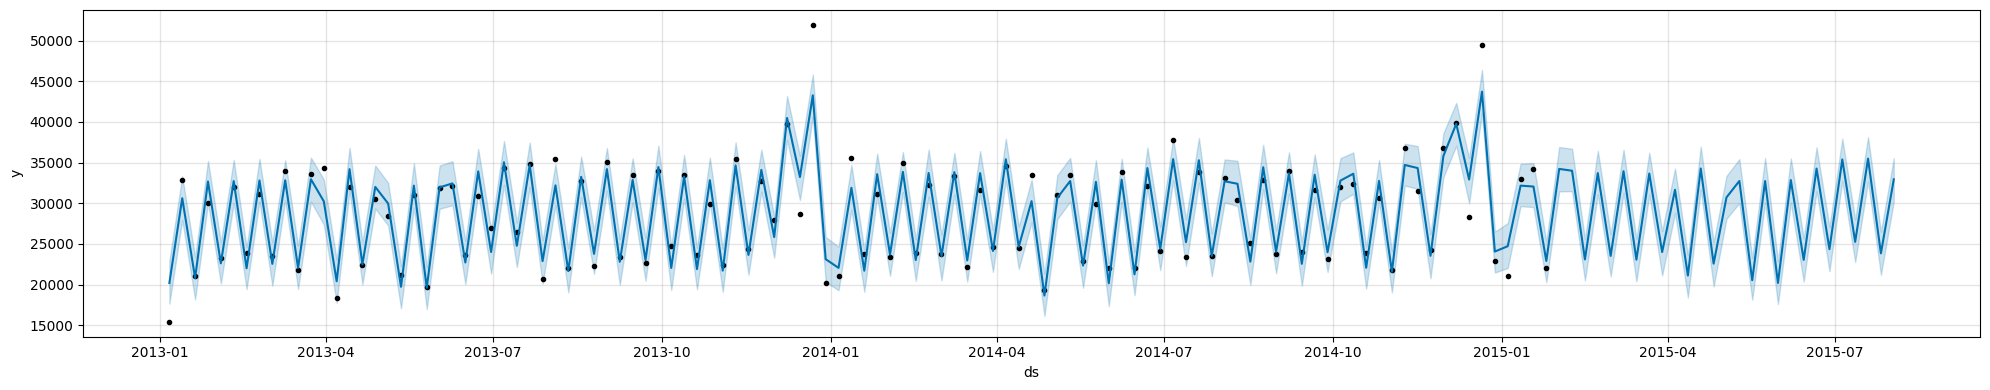

In [11]:
prophet_model.plot(forecast, figsize=(20, 4));

The Prophet model, it produces a plot that visualizes the forecast along with the historical data. Here's what you typically see in this plot:
1. **Historical Data**: The actual historical values are plotted, usually as black dots, showing the real data points that the model was trained on.
2. **Forecasted Values**: The model's predictions (forecast) are plotted as a blue line. This line represents the `yhat` values, showing the model's forecast for both the historical period (for comparison) and the future periods.
3. **Uncertainty Intervals**: Around the forecasted trend line, you will see a shaded area, which represents the uncertainty intervals of the forecast. This area is typically blue and shows the `yhat_lower` and `yhat_upper` values. It gives a visual representation of the potential variability of the forecast, indicating where the actual values might fall.

By analysing the plot we can conclude:
- The forecast line generally follows the historical data's pattern, suggesting that the model fits the historical data reasonably well.
- The shaded area, which represents uncertainty intervals, is relatively wide. This suggests that while the model has identified the pattern in historical data, there is still a significant amount of uncertainty in the predictions.
- There are several points where the actual sales (black dots) fall outside the uncertainty intervals. These outliers may indicate special events or anomalies that were not captured by the model.
- Considering the presence of outliers and the width of the uncertainty intervals, there may be room to improve the model. This could involve adding additional regressors, adjusting for holidays or special events, or revisiting the treatment of outliers.

Now we can visualize the components of the time series (trend, yearly seasonality, weekly seasonality, holidays, etc.) using the plot_components method. This will generate a plot with multiple subplots showing the different components separated out.

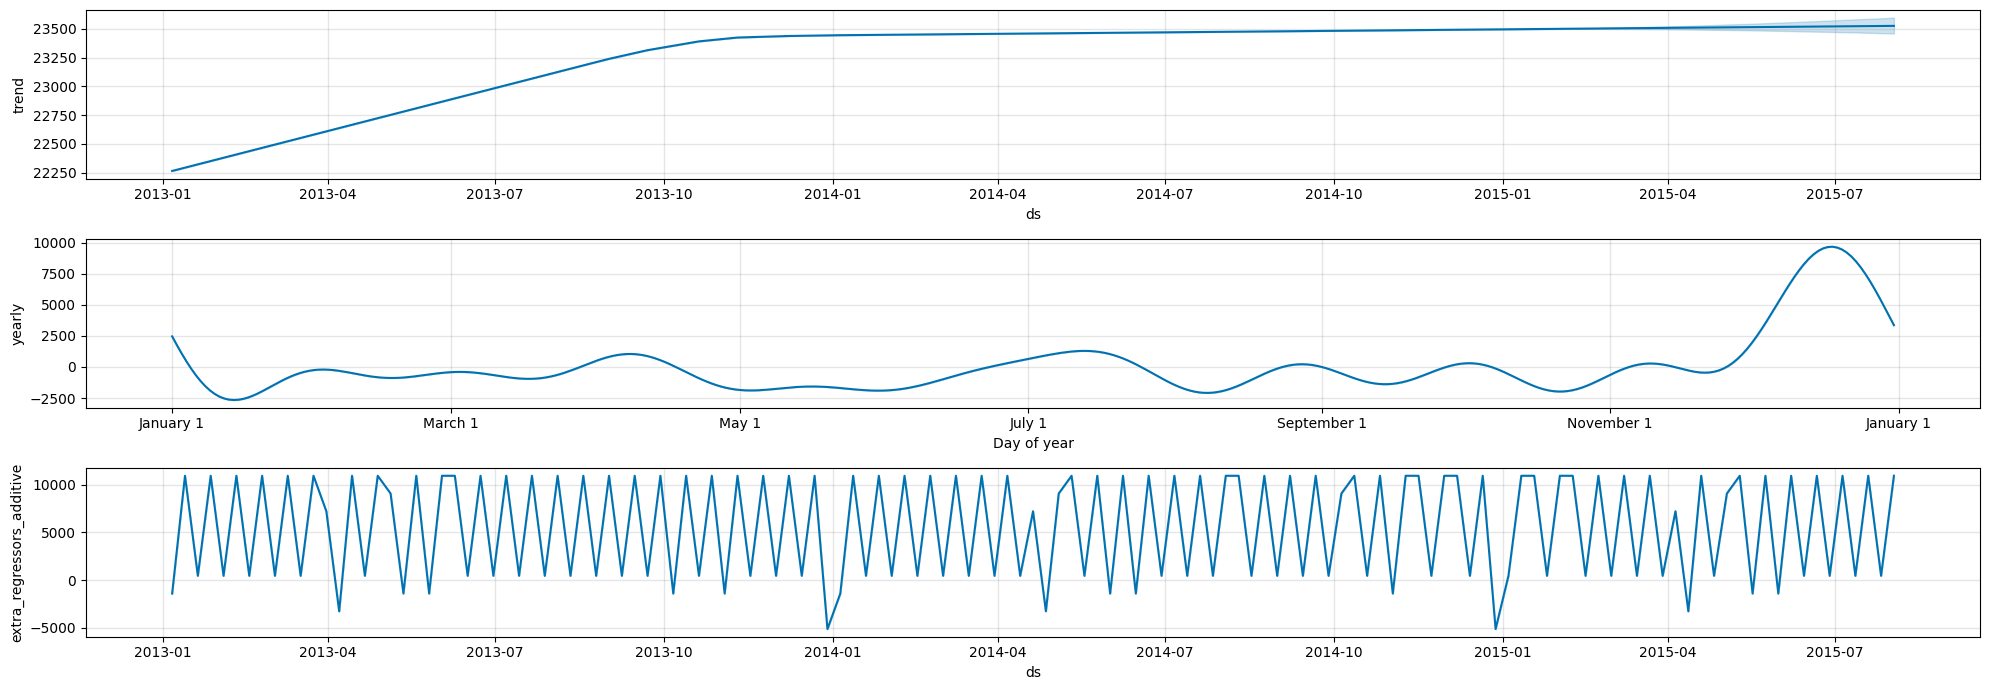

In [12]:
prophet_model.plot_components(forecast, figsize=(20, 7));

For our case, the plot generated by the `plot_components` function from Prophet displays three separate components of the time series model: **trend**, **yearly seasonality**, and the **effects of the additional regressors**.
- The **trend component** captures long-term changes in the data, excluding seasonal effects. In this case, the trend appears to be relatively stable initially, then shows a slight increase.
- The **yearly seasonality component** displays a peak around the end of the year, which could correspond to seasonal events like holidays or end-of-year sales. It's important to note that the seasonality pattern repeats annually, as indicated by the cyclic nature of the plot.
- The **effects of the additional regressors plot** shows that, on certain days or periods, there is a consistent and repeatable increase or decrease in the forecasted value due to these additional regressors, suggesting that the model has identified and quantified the impact of these additional variables, and they should be considered when making business decisions or preparing for future sales activities.

Now let's compare the forecasted values with the original train and test data.

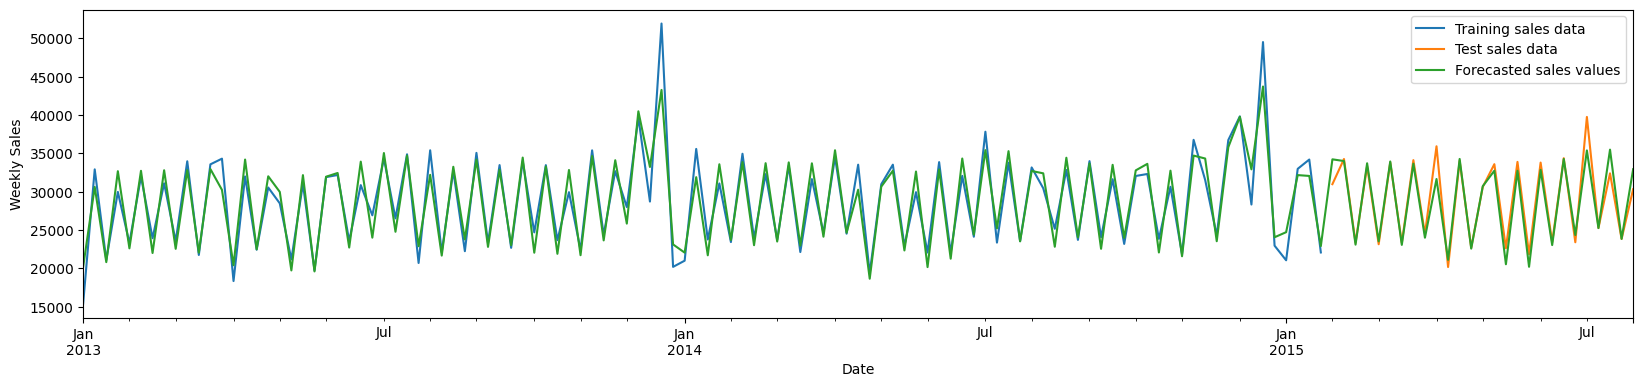

In [13]:
ax = train_df.set_index("ds")["y"].plot(label="Training sales data", kind="line", figsize=(20, 4))
test_df.set_index("ds")["y"].plot(label="Test sales data", kind="line", ax=ax)

forecast.set_index("ds")["yhat"].plot(label="Forecasted sales values", kind="line", ax=ax)30, 7

plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend();

- The model seems to fit the training data (in blue) quite well. The forecasted sales values (in green) are closely following the pattern of the training data, suggesting that the model has captured the underlying trend and seasonality effectively.
- During the period covered by the test data (in orange), the forecasted values continue to follow the actual sales reasonably well, though with some deviations, indicating that there might be room for improvement.

Let's check the residuals.

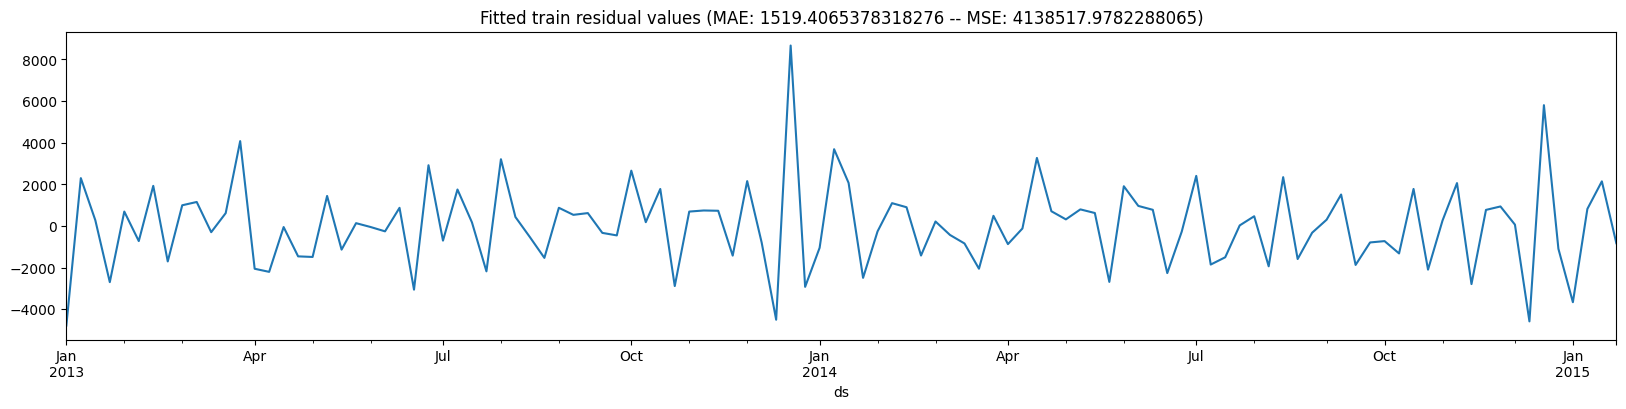

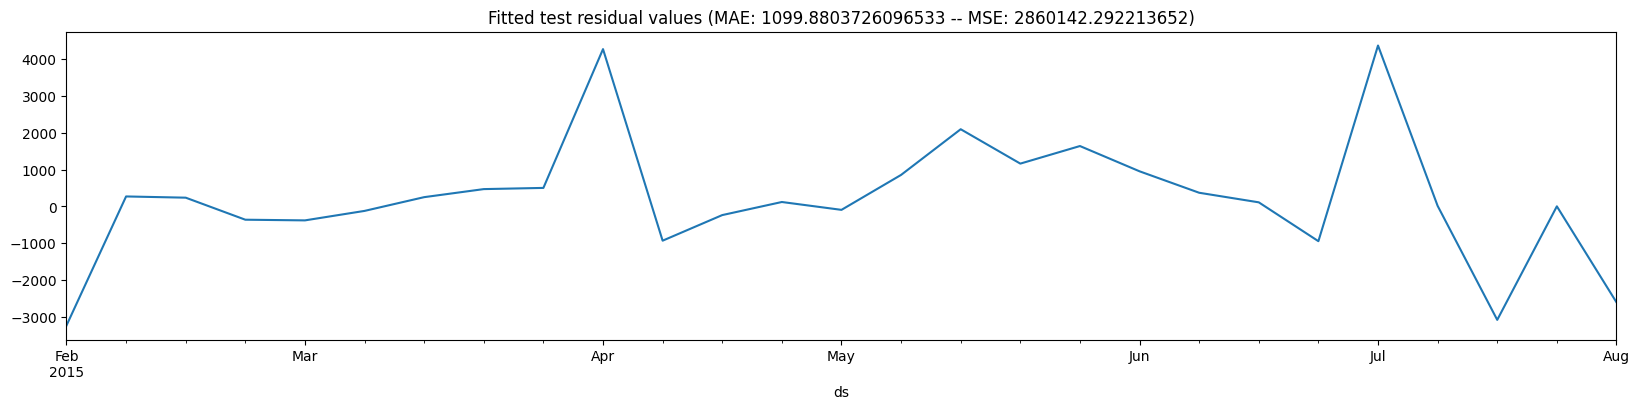

In [14]:
forecasted_train_df = forecast.iloc[:-test_len].set_index("ds", drop=True)
train_sales = train_df.set_index("ds", drop=True)["y"]
train_residuals = train_sales - forecasted_train_df["yhat"]
train_mae = mean_absolute_error(train_sales, forecasted_train_df["yhat"])
train_mse = mean_squared_error(train_sales, forecasted_train_df["yhat"])

forecasted_test_df = forecast.iloc[-test_len:].set_index("ds", drop=True)
test_sales = test_df.set_index("ds", drop=True)["y"]
test_residuals = test_sales - forecasted_test_df["yhat"]
test_mae = mean_absolute_error(test_sales, forecasted_test_df["yhat"])
test_mse = mean_squared_error(test_sales, forecasted_test_df["yhat"])

plt.figure()
plt.title(f"Fitted train residual values (MAE: {train_mae} -- MSE: {train_mse})")
train_residuals.plot(label="Fitted train residual values", kind="line", figsize=(20, 4));

plt.figure()
plt.title(f"Fitted test residual values (MAE: {test_mae} -- MSE: {test_mse})")
test_residuals.plot(label="Fitted test residual values", kind="line", figsize=(20, 4));

As we could see with the approach using SARIMAX, the Mean Absolute Error (MAE) and Mean Squared Error (MSE) of the forecasted test values are lower than those of the forecasted train values, and the reasoning is the same. But this time, we can see that magnitude of the residuals are significantly lower than with the SARIMAX model, indicating a improvement in the forecasting power.